# ⬇⬇⬇⬇⬇⬇⬇ Contrastive Learning for Entity-Matching ⬇⬇⬇⬇⬇⬇⬇

## Transformer Encoder For Enity matching
Using transformers to encode names can be very useful from various aspects 

In [1]:
!pip install -q -r requirements.txt

In [2]:
# !pip install -q -U sentence-transformers

In [1]:
import sys
import os
import pandas as pd
# import numpy as np
import numpy as np
import cupy as cp
from pathlib import Path
import sys 
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.append(os.path.abspath('..'))

# Read data files

In [15]:
filtered_path = 'data/sp-company-data'
filtered_name = 'filtered_ciqcompany'
filtered_norm_path = 'data/sp-company-data-normalized'
filtered_norm_name = 'normalized'

In [16]:
from matcher.utils import read_files

col_names = ['companyid','companyname']
all_filtered_norm = read_files(filtered_norm_path, filtered_norm_name, col_names, sep='\t')
# all_filtered_source = read_files(filtered_path, filtered_name, col_names)
# all_filtered_source = all_filtered_source.astype({'companyid': 'int64'})


>> Num of files: 38


In [17]:
# all_filtered_source.set_index('companyid', inplace=True)
all_filtered_norm.set_index('companyid', inplace=True)

In [2]:
## Read matched frame
matched_frame  = pd.read_csv('data/inferess-sp-ciq-matched-names.tsv', sep='\t')
## read Infress database
inferess_comp = pd.read_csv('data/preview-sec-gen-07-set-02-rev-01-2015-2022-company.tsv', sep='\t')
inferess_comp.set_index('inferess_entity_id', inplace=True)


redgraphs = pd.read_csv('data/redgraphs-sp-20230101T162735.tsv',sep='\t')

accepted_v01 = pd.read_csv('data/output/accepted_v02.tsv',sep='\t')
candidates_v01 = pd.read_csv('data/output/candidates_v02.tsv',sep='\t')

In [3]:
candidate_ids  = candidates_v01['candidates_ids'].apply(lambda x : x.split(',')).tolist()

In [4]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [5]:
candidate_ids = flatten_list(candidate_ids)

In [6]:
candidate_ids = [int(x) for x in candidate_ids]

In [7]:
candidate_ids += accepted_v01['source_id'].tolist()

In [8]:
import json 

candidates_v01['candidates_ids'].tolist()[0].split(',')

['595097235', '650003033', '39506238', '589155560', '1676271688']

In [9]:
type( accepted_v01['source_id'].tolist()[0])

int

In [10]:
redgraphs.columns

Index(['inferess_entity_id', 'sp_ciq_id'], dtype='object')

In [11]:
len(candidate_ids)

71884

In [12]:
redgraphs = redgraphs[redgraphs['inferess_entity_id'].isin(inferess_comp.index)]

In [18]:
redgraphs = redgraphs[redgraphs['sp_ciq_id'].isin(all_filtered_norm.index)]

In [19]:
missed = redgraphs[~redgraphs['sp_ciq_id'].isin(candidate_ids)]

In [20]:
missed.drop_duplicates(['sp_ciq_id'],inplace = True)
missed.drop_duplicates(['inferess_entity_id'],inplace = True)

/tmp/ipykernel_168/4272333703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed.drop_duplicates(['sp_ciq_id'],inplace = True)
/tmp/ipykernel_168/4272333703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed.drop_duplicates(['inferess_entity_id'],inplace = True)


In [21]:
missed['inferess_name'] = inferess_comp.loc[missed.inferess_entity_id]['normalized_name'].tolist()

/tmp/ipykernel_168/209932226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed['inferess_name'] = inferess_comp.loc[missed.inferess_entity_id]['normalized_name'].tolist()


In [22]:
all_filtered_norm = all_filtered_norm[~all_filtered_norm.index.duplicated()]

In [23]:
missed['sp_name'] = all_filtered_norm.loc[missed.sp_ciq_id]['companyname'].tolist()

/tmp/ipykernel_168/1323381280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed['sp_name'] = all_filtered_norm.loc[missed.sp_ciq_id]['companyname'].tolist()


In [24]:
missed.columns

Index(['inferess_entity_id', 'sp_ciq_id', 'inferess_name', 'sp_name'], dtype='object')

In [25]:
missed = missed[missed['inferess_entity_id'].astype('str').str.startswith('9')]

In [56]:
from matcher.core import SimCSE_Matcher
model_path = 'sentence-transformers/all-MiniLM-L6-v2'
model_name= 'data/artifacts/all-MiniLM-Norm/checkpoint-5000'
model_name = 'data/artifacts/all-MiniLM-Nli-v02'
# model_name= 'data/artifacts/all-MiniLM-Norm-v02'
model_name = 'data/artifacts/all-MiniLM-Nli-All-Pos-v01'

# model_name = 'data/artifacts/all-MiniLM-Nli-All-Random-v02'
model_name = 'data/artifacts/all-MiniLM-Nli-All-Real-v01'
model_name = 'data/artifacts/data/artifacts/all-MiniLM-Nli-All-Random-v03'


In [60]:
exp = 'all-MiniLM-Nli-All-Random-v4'
model_name = f'data/artifacts/{exp}'

In [61]:
simcse_model = SimCSE_Matcher(model_name)
simcse_model2 = SimCSE_Matcher(model_path)

Some weights of the model checkpoint at data/artifacts/all-MiniLM-Nli-All-Random-v4 were not used when initializing BertModel: ['mlp.dense.weight', 'mlp.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at data/artifacts/all-MiniLM-Nli-All-Random-v4 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
sims = simcse_model.similarity(missed['inferess_name'].tolist() , missed['sp_name'].tolist())
sims2 = simcse_model2.similarity(missed['inferess_name'].tolist() , missed['sp_name'].tolist())

100%|██████████| 46/46 [00:00<00:00, 53.19it/s]


In [30]:
missed['sim_score'] = sims.diagonal()
missed['sim_score2'] = sims2.diagonal()

In [31]:
pd.set_option('display.max_rows', 500)

In [32]:
missed.sim_score.describe() 

count    2902.000000
mean        0.779978
std         0.129629
min         0.116830
25%         0.706163
50%         0.809291
75%         0.877060
max         1.000000
Name: sim_score, dtype: float64

In [67]:
simcse_model2.similarity('metadata', '')

100%|██████████| 1/1 [00:00<00:00, 81.10it/s]


0.8980883359909058

In [56]:
missed[(missed['sim_score'] < 0.4)|(missed['sim_score2'] < 0.8)].shape

(138, 6)

In [48]:
missed[missed['sim_score'] < 0.5]

,inferess_entity_id,sp_ciq_id,inferess_name,sp_name,sim_score,sim_score2
20026,90100000250,664403164,Cessna,Cessna Ltd,0.495913,0.986287
20057,90100000497,47197267,FX,FX Corp Ltd,0.448571,0.953813
20120,90100001665,136795904,Yale,The Yale Corp,0.379611,0.975787
20164,90100003104,664857258,SOA,SOA SARL,0.495636,0.859862
20273,90100004877,659887110,Manufacturing,The Manufacturing Corp Ltd,0.489583,0.936024
20344,90100005729,664369412,Tazo,Tazo Ltd,0.489811,0.972736
20433,90100007084,112021825,Services,AB Services,0.368277,0.829780
20574,90100009433,684907811,Pepsi,Pepsi BV,0.486056,0.902960
20881,90100015437,216337001,Buster,Buster SA,0.409134,0.924151
20939,90100016401,628509852,Nylon,Nylon Ltd,0.444340,0.965220


In [59]:
predictions = pd.read_json('data/All-Pos-V02-Matches.json')

In [64]:
predictions[predictions.score.isna()]

,query,pred,score,matches
66,33 Degrees MS,None,NaN,None
1838,Additional major customer,None,NaN,None
1873,Adjusted Property EBITDA,None,NaN,None
2137,Affairs Million Veteran Program,None,NaN,None
2296,Ahlstrom,None,NaN,None
2298,Ahold Delhaize,None,NaN,None
2747,Allen Combined Cycle Plant,None,NaN,None
2942,Alphabet Inc. (formerly Google),None,NaN,None
3558,Amphetamine IR Tablets,None,NaN,None
3641,Ancillary Digital Spectrum,None,NaN,None


,inferess_entity_id,sp_ciq_id,inferess_name,sp_name,sim_score
20017,90100000091,705936,Motion Industries,Motion Industries Inc,0.989101
20018,90100000106,1050232,Wencor Group,Wencor Group LLC,0.974168
20019,90100000142,634812159,CBC Group,CBC Group Inc,0.987793
20020,90100000160,27405698,Rio Ammunition,Rio Ammunition Inc,0.985029
20025,90100000249,330410826,Bell Helicopter,Bell Helicopter KK,0.906431
...,...,...,...,...,...
34852,90101617007,554425485,PROPERTIES Inc,PROperties Inc,1.000000
34885,90101621499,25071561,DEKRA Certification,Dekra Certification GmbH,0.990001
34931,90101627094,4172302,Jefferies International,Jefferies International Ltd,0.984961
35001,90101638162,7405095,PLATFORM solutions,Platform Solutions Inc,0.960880


In [28]:
## get normalized text from filtered normalized using companyid which is index column 
matched_frame['sp_ciq_norm'] = all_filtered_norm.loc[matched_frame.sp_ciq_id,'companyname'].tolist()

In [18]:
matched_frame.drop_duplicates(['normalize_name'],inplace=True)

In [19]:
a = matched_frame[['reference_name', 'normalize_name']]
b = matched_frame[['sp_ciq_name','sp_ciq_norm']]

In [20]:
a.isnull().sum(), b.isnull().sum()

(reference_name    8285
 normalize_name       0
 dtype: int64,
 sp_ciq_name    0
 sp_ciq_norm    0
 dtype: int64)

In [21]:
a = a.rename(columns={'reference_name':'name'}).reset_index(drop=True)
b = b.rename(columns={'sp_ciq_name':'name'}).reset_index(drop=True)

a = a.rename(columns={'normalize_name':'norm'}).reset_index(drop=True)
b = b.rename(columns={'sp_ciq_norm':'norm'}).reset_index(drop=True)


In [22]:
a = a.astype({"name": str}, errors='raise')
b = b.astype({"name": str}, errors='raise')


In [25]:
import neattext as ntx
import re
def preprocess(x):
    x = re.sub(r"[\*\"\n\\…\+\-\/\=\(\)‘'•€\[\]\|♫:;—,.”“~`#]", " ", x) 

#     x = ntx.replace_term(x, ' And ','')
#     x = ntx.replace_term(x, '&','')
#     x = ntx.replace_term(x, 'The','')
    
    # x = ntx.replace_term(x, 'aktiengesellschaft','ag')
    # x = ntx.replace_term(x, 'public company limited','pcl')
    # x = ntx.replace_term(x, 'public limited company','plc')
    # x = ntx.replace_term(x, 'limited partnership','lp')
    # x = ntx.replace_term(x, 'limited liability company','llc')    
    # x = ntx.replace_term(x, 'société anonyme','sa')
    # x = ntx.replace_term(x, 'the','')
    # x = ntx.replace_term(x, 'private','pvt')    
    # x = ntx.replace_term(x, 'limited','ltd')
    # x = ntx.replace_term(x, 'company','co')
    # x = ntx.replace_term(x, 'incorporated','inc')
    # x = ntx.replace_term(x, 'corporation','corp')
    # # x = ntx.replace_term(x, ' ','')

    return x 

In [131]:
a['norm_ws'] = a['norm'].apply(preprocess).apply(lambda x : ntx.replace_term(x, ' ','')) 
b['norm_ws'] = b['norm'].apply(preprocess).apply(lambda x : ntx.replace_term(x, ' ','')) 

# Create dataset for Entity Linking

Train a neural network to encode enities into dense dimension represent the charaters that match two entities# Create an dataset fot entity linking 

1. Collect positive links: 
`Collect highly scored names with the rule based methods that guarantee correctness of the matching`
---
2. Collect hard negative links:
`Hard negative matches means pretty close but not match to distinguish the distinct point that match between two names`
---
3. Symbol and what it stand for: 
`This hopefully will allow the neural networt to understand if some words can match it's intials`
---
4. Leverage the SME knowledge base to create some fake examples: 
`Searching for hard patterns like:`
- two words have no space between them
- some symbols used as short cut
- create fake shortcuts and real one as pos and neg samples



In [18]:
from Levenshtein import distance, ratio


In [19]:

%%time
from tqdm import tqdm
d = a
similarities = np.zeros((d.shape[0], d.shape[0]))

for i in tqdm(range(4314,len(d))):
    for j in range(len(d)):
        similarities[i][j] = ratio(a.iloc[i]['norm'], b.iloc[j]['norm'] )


 56%|█████▌    | 10788/19371 [4:51:08<3:51:37,  1.62s/it]


KeyboardInterrupt: 

In [24]:
np.save("data/sim2.npy", similarities[4314:15102])

In [ ]:
neg_dict = {'word':[], 'neg':[]} 
for i,sim in enumerate(similarities):
    sorted = np.argsort(sim,axis=0)
    top_sim = sorted[::-1][1:20]
    top_sim = top_sim[np.where(sim[top_sim] >= 0.7)]
    word = a.iloc[i]['name']
    sim_neg = b.iloc[top_sim]['name'].tolist() 
    neg_dict['word'] += [word]*len(sim_neg)

    neg_dict['neg'] += sim_neg



pd.DataFrame(neg_dict).to_json('data/neg_names.json')

In [16]:
neg_name = pd.read_json('data/neg_names.json')

In [31]:
neg_name['norm'] = neg_name['word'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

neg_name['norm_ws'] = neg_name['norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 

neg_name['neg_norm'] = neg_name['neg'].apply(lambda x :re.sub(r"(\w)([A-Z])", r"\1 \2", ' '.join([s.capitalize() if len(s) < 5 else s for s in x.split()])))\
    .apply(lambda x : x.lower()).apply(preprocess)

neg_name['neg_norm_ws'] = neg_name['neg_norm'].apply(lambda x : ntx.replace_term(x, ' ','') ) 


In [32]:

positives = list(zip(a.norm_ws.tolist(),b.norm_ws.tolist()))
negatives = list(zip(neg_name.norm_ws.tolist(),neg_name.neg_norm_ws.tolist() ) )


X_train = positives + negatives
y_train = [1]*len(positives) + [0]*len(negatives)

assert len(X_train) == len(y_train)

pd.DataFrame({"X_train":X_train,'y_train':y_train} ).to_json('data/training_data_v1.json')



In [17]:
shuffle = True 
train_data = pd.read_json('data/training_data_v1.json')
if shuffle: 
    train_data = train_data.sample(frac=1)

In [18]:
train_data

,X_train,y_train
55971,"[bulova corp, lion corp]",0
3300,"[boston college, boston college]",1
42383,"[ariva ehf, artisan ehf]",0
28607,"[att inc, oath inc]",0
21216,"[toll bros inc, toll brors inc]",1
...,...,...
15318,"[oasis power llc, oasis power llc]",1
18740,"[saudi fooddrug authority, saudi fooddrug auth...",1
21223,"[tommy hilfiger corp, tommy hilfiger corp]",1
47718,"[bgc llc, vtc llc]",0


In [37]:
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None

train_data.sample(20)

,X_train,y_train
35031,"[alleteinc, atexinc]",0
33542,"[airgasinc, arazuinc]",0
3712,"[cedromsniinc, cedromsniinc]",1
21695,"[upmcchildren'shospitalofpittsburgh, upmcchildren'shospitalofpittsburgh]",1
53328,"[bitzioinc, itroninc]",0
18194,"[sdc, sdc]",1
12760,"[mddsrl, mddsrl]",1
38964,"[amrepcorp, arielcorp]",0
6812,"[essabancorpinc, essabancorpinc]",1
11539,"[kochenergyservicesllc, kochenergyservicesllc]",1


# Train Simcse Supervised

# Model name

In [25]:
model_name = 'sentence-transformers/all-MiniLM-L6-v2'

# Use Hugging Face encoder

In [21]:
# from transformers import AutoTokenizer, AutoModel
# import torch
# import torch.nn.functional as F

# #Mean Pooling - Take attention mask into account for correct averaging
# def mean_pooling(model_output, attention_mask):
#     token_embeddings = model_output[0] #First element of model_output contains all token embeddings
#     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
#     return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# # Sentences we want sentence embeddings for
# sentences = ['This is an example sentence', 'Each sentence is converted']

# # Load model from HuggingFace Hub
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# # Tokenize sentences
# encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# # Compute token embeddings
# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Perform pooling
# sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# # Normalize embeddings
# sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)


# Fine-tune SimCSE 
***using simcse technique for contrastive learning by adding hard_negative column***

In [30]:
model_path = 'sentence-transformers/all-MiniLM-L6-v2'
train_file= 'data/train/merged_norm_source.csv'
output_dir = 'data/artifacts/all-MiniLM-Norm_v01' 


In [127]:
merged_data.sample(500000).reset_index(drop=True).to_csv('data/train/sample_merged.csv',index=False)

In [157]:
!python train_simcse.py \
        --model_name_or_path  sentence-transformers/all-MiniLM-L6-v2\
        --train_file data/train/merged_norm_source.csv \
        --output_dir data/artifacts/all-MiniLM-Norm-v02\
        --num_train_epochs 1 \
        --per_device_train_batch_size 128 \
        --learning_rate 3e-5 \
        --save_steps 100000 \
        --max_seq_length 20 \
        --pooler_type cls\
        --temp 0.05\
        --do_train\
        --overwrite_output_dir
        

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
OurTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
eval_transfer=False,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_ac

# Simcse Encoder

In [23]:
from matcher.core import SimCSE_Matcher
model_path = 'sentence-transformers/all-MiniLM-L6-v2'
# model_name= 'data/artifacts/all-MiniLM-Norm/checkpoint-5000'
model_name = 'data/artifacts/all-MiniLM-Nli-v02'
model_name= 'data/artifacts/all-MiniLM-Norm-v02'
# model_name = 'data/artifacts/all-MiniLM-Nli-All-v01'
# model_name = 'data/artifacts/all-MiniLM-Nli-All-Real-v01/checkpoint-30000'
model_name= 'data/artifacts/all-MiniLM-Nli-All-Random-v01'
model_name= 'data/artifacts/data/artifacts/all-MiniLM-Nli-All-Random-v03'

model_name = 'data/artifacts/all-MiniLM-Nli-All-Real-v01'

In [24]:
simcse_model = SimCSE_Matcher(model_name)

Some weights of the model checkpoint at data/artifacts/all-MiniLM-Nli-All-Real-v01 were not used when initializing BertModel: ['mlp.dense.weight', 'mlp.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at data/artifacts/all-MiniLM-Nli-All-Real-v01 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
# a['norm'] = a['name'].apply(lambda x : '-'.join(list(x))) 
# b['norm'] = b['name'].apply(lambda x : '-'.join(list(x))) 

In [59]:
feature = 'norm'

In [60]:
simcse_model.build_index(b[feature].tolist())

01/01/2023 18:32:38 - INFO - faiss.loader -   Loading faiss with AVX2 support.
01/01/2023 18:32:38 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
01/01/2023 18:32:38 - INFO - faiss.loader -   Loading faiss.
01/01/2023 18:32:39 - INFO - faiss.loader -   Successfully loaded faiss.
01/01/2023 18:32:39 - INFO - matcher.core -   Encoding embeddings for sentences...
100%|██████████| 370/370 [00:04<00:00, 84.61it/s]
01/01/2023 18:32:45 - INFO - matcher.core -   Building index...
01/01/2023 18:32:45 - INFO - matcher.core -   Use GPU-version faiss
01/01/2023 18:32:45 - INFO - matcher.core -   Finished


In [61]:
query = a['norm'].tolist()

In [62]:

def predict_match(simcse_model, query,return_type='dict', top_k=3,threshold=0.1):
    """ Get the desired outpur format for Faiss searcher
    
    @param
    ------
    - simcse_model(SimCSE object): that alreay built an index matrix for the target data we want query
    - query(Union[List,str]): query list or str
    - return_type(str): defines the data shape or format you want to return based on needs 
    - top_k(int): Max number of matches to return for each record 
    - threshold(float): similarity score threshold
    
    @return
    -------
    dict or list of matches with scores
    """
    results =  simcse_model.search(query, top_k=top_k,threshold=threshold)

    if return_type == 'dict':
        return [{query[i]: results[i]} for i in range(len(query))]
    
    elif return_type=='predictions': 
        return [r[0][0] for r in results], [r[0][1] for r in results]
    elif return_type == 'matches':
        return results

In [63]:
pred, score = predict_match(simcse_model ,query , return_type='predictions')

100%|██████████| 370/370 [00:03<00:00, 94.67it/s] 


In [64]:
matches =  predict_match(simcse_model ,query , return_type='matches',top_k=30,threshold=0.5)

100%|██████████| 370/370 [00:04<00:00, 90.94it/s]


In [65]:
d_results = pd.DataFrame({'query':query, 'pred':pred,'score':score, 'real_match':b[feature].tolist(), 'matches':matches})

In [66]:
founded = []
for i,row in d_results.iterrows():
    candidate = [r[0] for r in row['matches']]    
    if row['real_match'] in candidate:
        founded.append(1) 
    else:
        founded.append(0) 
d_results['founded'] = founded

In [67]:
d_results.columns

Index(['query', 'pred', 'score', 'real_match', 'matches', 'founded'], dtype='object')

In [68]:
simcse_model.similarity('HouseShiftltd','Houseshiftd')

100%|██████████| 1/1 [00:00<00:00, 113.69it/s]


0.9079053997993469

# Print mis_matched 

In [70]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_colwidth', 600)

mis_classified = d_results[d_results['pred'] != d_results['real_match']]
correct_classified = d_results[d_results['pred'] == d_results['real_match']]
(a.shape[0] - mis_classified.shape[0]) / a.shape[0]

0.9969114909460145

In [71]:
d_results.score.describe()

count    23636.000000
mean         0.996568
std          0.020890
min          0.596936
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000001
Name: score, dtype: float64

In [72]:
mis_classified.score.describe()

count    73.000000
mean      0.817626
std       0.084182
min       0.596936
25%       0.759304
50%       0.819106
75%       0.870132
max       0.990261
Name: score, dtype: float64

In [73]:
d_results[(d_results.score < 0.97) & (d_results.score >0.80)].shape


(720, 6)

In [75]:
sum(d_results['founded'] == 1) / len(d_results), len(d_results)-sum(d_results['founded'] == 1)

(0.9994076831951261, 14)

## Results of fine-tuning on pos-pairs (source,normalized)

### Score of highest score
- pre-trained -> `0.9921891492505805`
- all-MiniLM-Norm-v02 -> `0.9956090352543804`


### Score of Correctness 5 candidates 
- pre-trained -> `0.9959468017732742`
- all-MiniLM-Norm-v02 -> `0.9983956090352544`


In [76]:
real_score = simcse_model.similarity(mis_classified['query'].tolist(), mis_classified['real_match'].tolist())

100%|██████████| 2/2 [00:00<00:00, 97.62it/s]


In [77]:
mis_classified['real_score'] = real_score.diagonal()

/tmp/ipykernel_59/3659281082.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mis_classified['real_score'] = real_score.diagonal()


In [78]:
mis_classified.shape

(73, 7)

In [79]:
simcse_model.similarity('Center for Generational Kinetics LLC',  'Center for Generational Kinetics LLC')

100%|██████████| 1/1 [00:00<00:00, 105.24it/s]


1.0

In [80]:
mis_classified['query_tokenized'] =mis_classified['query'].apply(simcse_model.tokenizer.tokenize)
mis_classified['pred_tokenized'] =mis_classified['pred'].apply(simcse_model.tokenizer.tokenize)
mis_classified['real_tokenized'] =mis_classified['real_match'].apply(simcse_model.tokenizer.tokenize)

/tmp/ipykernel_59/3787030286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mis_classified['query_tokenized'] =mis_classified['query'].apply(simcse_model.tokenizer.tokenize)
/tmp/ipykernel_59/3787030286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mis_classified['pred_tokenized'] =mis_classified['pred'].apply(simcse_model.tokenizer.tokenize)
/tmp/ipykernel_59/3787030286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [81]:
sum(mis_classified['founded']==0) / len(mis_classified)

0.1917808219178082

In [82]:
mis_classified['query_tokenized'] =mis_classified['query'].apply(simcse_model.tokenizer.tokenize)
mis_classified['pred_tokenized'] =mis_classified['pred'].apply(simcse_model.tokenizer.tokenize)
mis_classified['real_tokenized'] =mis_classified['real_match'].apply(simcse_model.tokenizer.tokenize)

mis_classified['query_idx'] =mis_classified['query'].apply(simcse_model.tokenizer.encode)
mis_classified['pred_idx'] =mis_classified['pred'].apply(simcse_model.tokenizer.encode)
mis_classified['real_idx'] =mis_classified['real_match'].apply(simcse_model.tokenizer.encode)

/tmp/ipykernel_59/3175430085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mis_classified['query_tokenized'] =mis_classified['query'].apply(simcse_model.tokenizer.tokenize)
/tmp/ipykernel_59/3175430085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mis_classified['pred_tokenized'] =mis_classified['pred'].apply(simcse_model.tokenizer.tokenize)
/tmp/ipykernel_59/3175430085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [85]:
mis_classified

,query,pred,score,real_match,matches,founded,real_score,query_tokenized,pred_tokenized,real_tokenized,query_idx,pred_idx,real_idx
350,ALUMEC SRL,Alco Inc,0.858451,ALUMEC S.r.l,"[(Alco Inc, 0.85845107), (Alcan Inc, 0.85054904), (Alcon Inc, 0.8421066), (ALUMEC S.r.l, 0.8292303), (Alcoa Corp, 0.7917501), (Alon USA LP, 0.7597422), (Alico Inc, 0.7553352), (EACO Corp, 0.73523307), (Algar Inc, 0.7318892), (AGCO Corp, 0.7183362), (Alno AG, 0.71520853), (AL Gilbert Co, 0.7091232), (Ademco Inc, 0.7042866), (ALLETE Inc, 0.6952319), (AUM LLC, 0.6931725), (ALZA Corp, 0.6912403), (AGC Inc, 0.6744574), (Arenaco LLC, 0.67390835), (ALPHA Co Ltd, 0.6738417), (Aceto Corp, 0.6724209), (Alcam, 0.6712766), (The Axon LLC, 0.6701559), (A-Class Inc, 0.6695115), (Alticor Inc, 0.6682501), ...",1,0.829230,"[al, ##ume, ##c, sr, ##l]","[al, ##co, inc]","[al, ##ume, ##c, s, ., r, ., l]","[101, 2632, 17897, 2278, 5034, 2140, 102]","[101, 2632, 3597, 4297, 102]","[101, 2632, 17897, 2278, 1055, 1012, 1054, 1012, 1048, 102]"
968,Aerospace Manufacturing Co,Asiatelco Technologies Co,0.795286,Aerospace Manufacturing Corp,"[(Asiatelco Technologies Co, 0.7952864), (Utility Trailer Manufacturing Co, 0.7756212), (American Flange and Manufacturing Co Inc, 0.76231384), (Altus Midstream Co, 0.7575806), (Air Tool Service Co, 0.7564562), (AF Ocean Investment Management Co, 0.75611764), (Archer-Daniels-Midland Co, 0.75327235), (Valero Marketing and Supply Co, 0.7453081), (Paramount Manufacturing Co Inc, 0.7393266), (Garnero Group Acquisition Co, 0.73790634), (Vantage Drilling Co, 0.73502123), (Illinois Power Marketing Co, 0.7343995), (Lockheed Martin Aeronautics Co, 0.7331432), (Alps Alpine Co Ltd, 0.72404164), (Enco...",0,0.658131,"[aerospace, manufacturing, co]","[asia, ##tel, ##co, technologies, co]","[aerospace, manufacturing, corp]","[101, 13395, 5814, 2522, 102]","[101, 4021, 9834, 3597, 6786, 2522, 102]","[101, 13395, 5814, 13058, 102]"
1966,As Partner,AS Kevelt,0.857048,AS Partners,"[(AS Kevelt, 0.85704786), (As-Service, 0.8526648), (AS Partners, 0.83476925), (AS Enterprise, 0.79955417), (AS ENERGY, 0.7711735), (AS ONE Corp, 0.75057966), (As Liberty, 0.74283046), (AS Group, 0.7210053), (Ascent AG, 0.7197861), (Andeavor, 0.6997078), (ASI Corp, 0.69509584), (AirSep Corp, 0.6915813), (Avient Corp, 0.6915708), (As Taurus, 0.6888791), (Oracle Corp, 0.6879921), (ASDERA LLC, 0.6864904), (ASGN Inc, 0.68065614), (ASTM SpA, 0.67972445), (ASiQ Ltd, 0.66117847), (AIXTRON SE, 0.6603388), (Ascension ApS, 0.6480834), (Assurant Inc, 0.6475636), (ASML Holding NV, 0.64683187), (ASiQ Pt...",1,0.834769,"[as, partner]","[as, ke, ##vel, ##t]","[as, partners]","[101, 2004, 4256, 102]","[101, 2004, 17710, 15985, 2102, 102]","[101, 2004, 5826, 102]"
2409,BELLCO SRL,Blueco SRL,0.829449,Bellco S.r.l,"[(Blueco SRL, 0.8294486), (Bellco S.r.l, 0.8077163), (BD and Co Inc, 0.7638338), (Bitcoin, 0.75463605), (The Boler Co, 0.71583277), (Crawford and Co, 0.6963847), (BP Amoco Co, 0.69234216), (The Boeing Co, 0.69146883), (Campbell and Co Inc, 0.6787784), (FBR and Co, 0.6751542), (BDI Co Ltd, 0.6739663), (Brocade Co Inc, 0.6724961), (Buscar Co, 0.6714221), (BET Co Ltd, 0.66363806), (BCC Corp, 0.662694), (The Boulder Co, 0.66000915), (BOPCO LP, 0.6595298), (The Hockey Co, 0.65783733), (Cubrc Inc, 0.6526544), (Fisher And Co, 0.65085626), (BNC Bancorp, 0.6429154), (Kellogg Co, 0.64222866), (The C...",1,0.807716,"[bell, ##co, sr, ##l]","[blue, ##co, sr, ##l]","[bell, ##co, s, ., r, ., l]","[101, 4330, 3597, 5034, 2140, 102]","[101, 2630, 3597, 5034, 2140, 102]","[101, 4330, 3597, 1055, 1012, 1054, 1012, 1048, 102]"
2996,BioLine RX Ltd,Bioline,0.927365,BioLineRx Ltd,"[(Bioline, 0.9273647), (Biolife SRL, 0.78648186), (BioVie Inc, 0.7501195), (BioLineRx Ltd, 0.74135625), (Biotricity Inc, 0.73322415), (BioWa Inc, 0.72501355), (BioLite Inc, 0.70596373), (BI-LO LLC, 0.7003425), (Biocentric, 0.69245726), (Biogen Inc, 0.68906426), (BioNTech SE, 0.6737042), (Boulay PLLP, 0.67291456), (Biolix Corp, 0.6690193), (Bi

In [83]:
def print_queries(results, file=None):
    
    if file is not None: 
        with open(file, 'w') as f: 
            for r in results :
                f.write(f'Query =\n {list(r.keys())[0]}\n')
                f.write('-'*30 + '\n')
                f.write(f'Results =\n {list(r.values())[0]}\n')
                f.write('+'*80+ '\n')
    else:   
        for r in results :
            print('Query = ',list(r.keys())[0])
            print('-'*30)
            print('Results = ',*list(r.values())[0],sep='\n')
            print('+'*80)



In [84]:
results =  predict_match(simcse_model ,query , return_type='dict',top_k=3)
print_queries(results, 'reports/init_results_v03.txt')

100%|██████████| 370/370 [00:03<00:00, 97.03it/s] 


# Build NLI data using the similarity between query and non-matches
### By using the similarity and some tweeks in the data we can reach to good simulation of the erros that our encoder fall at 


In [130]:
from matcher.core import SimCSE_Matcher
## Load the pre-trained model 
simcse_model = SimCSE_Matcher(model_path)

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

## Create NLI examples from merged data

In [136]:
merged_data.index

RangeIndex(start=0, stop=4838031, step=1)

In [145]:
merged_data['lower1'] = merged_data['companyname_x'].apply(lambda x: x.lower())
merged_data['lower2'] = merged_data['companyname_y'].apply(lambda x: x.lower())

In [146]:
merged_data.shape

(4838031, 4)

In [147]:
merged_data.drop_duplicates(['lower1','lower2'],inplace=True)

In [149]:
merged_data.shape

(4817762, 4)

In [150]:
# Number of examples to use 
n_examples = 200_000
merged_sample = merged_data.sample(n_examples).reset_index(drop=True)

In [151]:
simcse_model.build_index(merged_sample['companyname_x'].tolist())

12/18/2022 21:12:05 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 3125/3125 [00:32<00:00, 96.14it/s] 
12/18/2022 21:12:38 - INFO - simcse.core -   Building index...
12/18/2022 21:12:38 - INFO - simcse.core -   Use GPU-version faiss
12/18/2022 21:12:38 - INFO - simcse.core -   Finished


In [152]:
results =  predict_match(simcse_model ,merged_sample['companyname_y'].tolist() , return_type='matches',top_k=7, threshold=0.85)

100%|██████████| 3125/3125 [00:34<00:00, 89.35it/s]


In [480]:
list(zip(merged_sample.head(10)['companyname_y'].tolist(),results[:10]))

[('PORTICO Kereskedelmi es Tanacsado Korlatolt Felelossegu Tarsasag',
  [('PORTICO Kereskedelmi és Tanácsadó Korlátolt Felelosségü Társaság',
    0.99999964),
   ('LEPOREX Állattenyésztési és Kereskedelmi Korlátolt Felelosségu Társaság',
    0.8311124),
   ('Portico Club LLC', 0.8208786),
   ('InterexWaga Kereskedelmi Korlatolt Felelossegu Tarsasag', 0.81754524),
   ('BFOUR Befekteto Korlatolt Felelossegu Tarsasag', 0.815158),
   ('Notincsi Kastély Kereskedelmi És Szolgáltató Korlátolt Felelosségu Társaság',
    0.8132827),
   ('PaTak Takarmanygyarto Es Ertekesito Korlatolt Felelossegu Tarsasag',
    0.8119444)]),
 ('AB Midlands Ltd',
  [('A B Midlands Limited', 0.93690485),
   ('Dpr Midlands Limited', 0.86792445),
   ('Midlands Consultancy Services Limited', 0.85234714),
   ('West Midlands Says No Limited', 0.8496095),
   ('Systems Design East Midlands Limited', 0.8393988),
   ('The Midlands Marketing Company Limited', 0.8341984),
   ('Midlands Asset Finance Limited', 0.8321953)]),
 (

In [162]:
from tqdm.auto import tqdm
nli_data = []
for i in tqdm(range(0,len(results))): 
    sent = merged_sample.iloc[i]['companyname_y']
    true = merged_sample.iloc[i]['companyname_x']
    pos_pairs =[sent,true] 
    
    similarities = [r[0] for r in results[i]]
    scores = [r[1] for r in results[i]]
    
     
    if true in similarities:
        similarities.remove(true)
    
    if len(similarities) == 0:
        continue
    errors = similarities
    l =[len(x.split()) for x in pos_pairs ]
    f = lambda i: l[i]
    max_id  = max(range(len(l)), key=f)
    if len(errors) >0 :
        sent0 = pos_pairs[max_id]
        sent1 = pos_pairs[max_id-1]
        hard_neg = errors[0]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        
    if len(errors) >1: 
        sent0 = r_space(pos_pairs[max_id])
        sent1 = pos_pairs[max_id-1]
        hard_neg = errors[1]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    if len(errors) >2:
        sent0 = pos_pairs[max_id]
        sent1 = r_space(pos_pairs[1-max_id])
        hard_neg = ' '.join(sent0.split())
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
 
    if len(errors) >3:
        sent0 = r_dots(pos_pairs[max_id])
        sent1 = pos_pairs[max_id-1]
        hard_neg = errors[3]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    if sent.split()[0].lower() !='the' or true.split()[0].lower() !='the': 
        sent0 = 'The '+sent
        sent1 = true 
        words = sent1.split()
        words.remove(words[randint(0,len(words)-1)])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    if len(sent.split()) > 3:
        sent0 = r_space(sent,space=' ',index=1)
        sent1 = r_space(true,space='-',index=1)
        words = sent.split()
        words.remove(words[1])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        sent0 = r_space(sent,space=' ',index=1)
        sent1 = r_space(true,space=' ',index=1)
        words = sent.split()
        words.remove(words[-1])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})


        
        

  0%|          | 0/200000 [00:00<?, ?it/s]

In [166]:
merged_nli = pd.DataFrame(nli_data)

In [167]:
merged_nli

,sent0,sent1,hard_neg
0,O'Keefe and O'Malley Inc,OKeefe OMalley Inc,Bushdokta Limited
1,O'K eefe and O'Malley Inc,OKeefe OMalley Inc,Wittmann Rücker Kyek Ellmauthaler Institut Für Ökologie Og
2,The O'Keefe and O'Malley Inc,OKeefe OMalley Inc,OKeefe Inc
3,O'Keefe a nd O'Malley Inc,OKeefe O-Malley Inc,O'Keefe O'Malley Inc
4,O'Keefe a nd O'Malley Inc,OKeefe O Malley Inc,O'Keefe and O'Malley
...,...,...,...
1128686,Hitachi Koki USA. Ltd. La Branch,Hitachi Koki USA Ltd La Branch,KoodiMiki OÜ
1128687,Hitach i Koki USA. Ltd. La Branch,Hitachi Koki USA Ltd La Branch,Konaki Limited
1128688,The Hitachi Koki USA. Ltd. La Branch,Hitachi Koki USA Ltd La Branch,Hitachi Koki USA Ltd Branch
1128689,Hitachi Ko ki USA. Ltd. La Branch,Hitachi Ko-ki USA Ltd La Branch,Hitachi USA. Ltd. La Branch


In [165]:
merged_nli.to_csv('data/train/mergen_nli.csv',index=False)

## Create NLI data using the pre-matched data

In [130]:
## Using the normalized data 
feature = 'norm'
simcse_model.build_index(b[feature].tolist())

12/17/2022 23:28:38 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 370/370 [00:02<00:00, 133.00it/s]
12/17/2022 23:28:40 - INFO - simcse.core -   Building index...
12/17/2022 23:28:40 - INFO - simcse.core -   Use GPU-version faiss
12/17/2022 23:28:41 - INFO - simcse.core -   Finished


In [131]:
## find matches
query = a['norm'].tolist() 
results =  predict_match(simcse_model ,query , return_type='matches',top_k=5, threshold=0.79)

100%|██████████| 370/370 [00:02<00:00, 123.97it/s]


In [32]:
from random import randint

def r_space(name,space=' ', index =0):
    words = name.split()
    if len(words)<index+1:
        return name 
    if len(words[index]) < 2:
        return name
    r_i = randint(1, len(words[index])-1)
    splitted = words[index][0:r_i] +space+ words[index][r_i:]
    words[index] = splitted
    return ' '.join(words)

In [33]:
def r_dots(name):
    words = name.split()
    words = name.split()
    dotted = '.'.join(words[0])
    c_name = dotted +' '+' '.join(words[1:])
    return c_name



In [34]:
from tqdm.auto import tqdm
import string
import random

nli_data = []
for i in tqdm(range(0,len(results))): 
    sent = a.iloc[i]['norm']
    true = b.iloc[i]['name']
    pos_pairs =[sent,true]
    
    similarities = [r[0] for r in results[i]]
    
    if true in similarities:
        similarities.remove(true)
    
    if len(similarities) == 0:
        continue
    errors = similarities
    l =[len(x.split()) for x in pos_pairs ]
    f = lambda i: l[i]
    max_id  = max(range(len(l)), key=f)
    if len(errors) >0:
        sent0 = pos_pairs[max_id]
        sent1 = pos_pairs[max_id-1]
        hard_neg = errors[0]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        
    if len(errors) >1: 
        sent0 = r_space(pos_pairs[max_id])
        sent1 = pos_pairs[max_id-1]
        hard_neg = errors[1]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    if len(errors) >2:
        sent0 = pos_pairs[max_id]
        sent1 = r_space(pos_pairs[1-max_id])
        hard_neg = errors[2]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
 
    if len(errors) >3:
        sent0 = r_dots(pos_pairs[max_id])
        sent1 = pos_pairs[max_id-1]
        hard_neg = errors[3]
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    if sent.split()[0].lower() !='the' or true.split()[0].lower() !='the': 
        sent0 = 'the '+sent
        sent1 = true
        words = sent1.split()
        words.remove(words[randint(0,len(words)-1)])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    if len(sent.split()) > 3:
        sent0 = r_space(sent,space=' ',index=1)
        sent1 = r_space(true,space='_',index=1)
        words = sent.split()
        words.remove(words[1])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        sent0 = r_space(sent,space=' ',index=1)
        sent1 = r_space(true,space=' ',index=1)
        words = sent.split()
        words.remove(words[-1])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        sent0 = r_dots(pos_pairs[max_id])
        sent1 = r_space(pos_pairs[1-max_id],space='+',index=1)
        hard_neg = r_space(sent,space=letters[0],index=1)
        letters = random.choices(string.ascii_lowercase, k=1)
        hard_neg = r_space(hard_neg,space=letters[0],index=0)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        
        sent0 = pos_pairs[max_id]
        sent1 = r_space(pos_pairs[1-max_id],space=' ',index=0)
        hard_neg = r_space(hard_neg,space=letters[0],index=0)
        words = sent.split()
        words.remove(words[0])
        hard_neg = ' '.join(words)
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
        
        
        
    



NameError: name 'results' is not defined

In [28]:
!pip install -q Random-Word

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient 2.0.5 requires attrs<=19, but you have attrs 22.2.0 which is incompatible.


In [29]:
from random_word import RandomWords
r = RandomWords()

# Return a single random word
r.get_random_word()

'rewish'

# Random NLI

In [42]:
from tqdm.auto import tqdm
import random
import string
nli_data = []
for i in tqdm(range(2000)):
    word0 = r.get_random_word()
    word1 = r.get_random_word()
    '''
    POS: two words seperated
    NEG: Second word different
    '''
    sent0 = ' '.join([word0,word1])
    sent1 = word0+word1.capitalize()
    hard_neg = ' '.join([word0,r.get_random_word()])
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    '''
    POS: split first word
    NEG: first word different
    '''
    sent0 = ' '.join([' '.join(list(word0)) ,word1])
    sent1 = word0+' '+word1.capitalize()
    hard_neg = ' '.join([r.get_random_word(),word1])
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    '''
    POS: same name with `the` 
    NEG: and random Chars at the end
    '''
    end = ''.join(random.choices(string.ascii_lowercase, k=3)).upper()
    sent0 = 'The ' + ' '.join([word0,word1]) +' '+ end
    sent1 = ' '.join([word0,word1])+ ' ' + end
    hard_neg = word0+' '+word1+ ' ' + ''.join(random.choices(string.ascii_lowercase, k=3)).upper()
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    '''
    POS: same name without title
    NEG: and random Chars at the end
    '''
    end = ''.join(random.choices(string.ascii_lowercase, k=3)).upper()
    end1 = ''.join(random.choices(string.ascii_lowercase, k=3)).upper()
    
    sent0 = word0 + ' ' + end
    sent1 = word0
    hard_neg = word1
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    sent0 = word1 + ' ' + end + ' ' +end1
    sent1 = word1
    hard_neg = word0
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    sent0 = word0 + ' ' + word1 + ' ' + end + ' ' +end1
    sent1 = ' '.join([word0,word1])
    hard_neg =  r.get_random_word()
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    

    '''
    POS: And Between words 
    NEG: different chars at the start
    '''
    sent0 = ' '.join([word0,'And',word1])
    sent1 = ' '.join([word0,word1])
    hard_neg = ''.join(random.choices(string.ascii_lowercase, k=2)).capitalize()+word0 + ' ' + word1
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    '''
    POS: And Between words 
    NEG: different chars at the start
    '''
    
    for c in ['s','i', 'a', 'e','ies','u']:
        shift = 1
        sent0 = word0+c+' '+word1 if shift==1 else word0+' '+word1+c
        sent1 = ' '.join([word0,word1])
        hard_neg  = r_space(word0,space= ''.join(random.choices(string.ascii_lowercase, k=2)))+ ' ' +r_space(word1,space= ''.join(random.choices(string.ascii_lowercase, k=2)))
        shift = 1-shift
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})


    for r_i in range(1,len(word0)):
        space = random.choice([' '])
        sent0 = word0
        splitted = word0[0:r_i] +space+ word0[r_i:]
        sent1 = splitted
        hard_neg  = r_space(word0,space= ''.join(random.choices(string.ascii_lowercase, k=2)))+ ' ' +r_space(word1,space= ''.join(random.choices(string.ascii_lowercase, k=2)))
        nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    
    sent0 = ' '.join(list(word0))
    sent1 = word0
    hard_neg = word1
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})
    
    
    sent0 = ' '.join(list(word1))
    sent1 = word1
    hard_neg = word0
    nli_data.append({'sent0':sent0, 'sent1':sent1, 'hard_neg':hard_neg})


  0%|          | 0/2000 [00:00<?, ?it/s]

In [43]:
rand_nli = pd.DataFrame(nli_data)

In [44]:
rand_nli

,sent0,sent1,hard_neg
0,ungreeable anticum,ungreeableAnticum,ungreeable habitable
1,u n g r e e a b l e anticum,ungreeable Anticum,gasan anticum
2,The ungreeable anticum BUQ,ungreeable anticum BUQ,ungreeable anticum WOG
3,ungreeable LFC,ungreeable,anticum
4,anticum LFC VGZ,anticum,ungreeable
...,...,...,...
46641,bargemen,barge men,bargemecmn conservationismtt
46642,bargemen,bargem en,bacvrgemen conservationirbst
46643,bargemen,bargeme n,bargeixmen conservationieqst
46644,b a r g e m e n,bargemen,conservationist


In [45]:
rand_nli.to_csv('data/train/random_words_v05.csv',index=False)

In [46]:
pd.read_csv('data/train/random_words_v05.csv')

,sent0,sent1,hard_neg
0,ungreeable anticum,ungreeableAnticum,ungreeable habitable
1,u n g r e e a b l e anticum,ungreeable Anticum,gasan anticum
2,The ungreeable anticum BUQ,ungreeable anticum BUQ,ungreeable anticum WOG
3,ungreeable LFC,ungreeable,anticum
4,anticum LFC VGZ,anticum,ungreeable
...,...,...,...
46641,bargemen,barge men,bargemecmn conservationismtt
46642,bargemen,bargem en,bacvrgemen conservationirbst
46643,bargemen,bargeme n,bargeixmen conservationieqst
46644,b a r g e m e n,bargemen,conservationist


In [171]:
pd.concat([pd.read_csv(f'data/train/random_words_v0{i}.csv') for i in [1,2,3,4,5]] +\
          [pd.read_csv('data/train/nli_data_v03.csv')]+\
          [pd.read_csv('data/train/mergen_nli.csv')],axis=0).reset_index(drop=True).to_csv('data/train/all_nli_v01.csv',index=False)

In [ ]:
for i in range(10000):
    word0 = r.get_random_word()
    word1 = r.get_random_word()
    
    sent0 = ' '.join([word0,word1])
    sent1 = word0+word1.capitalize()

In [135]:
s = 'the Comm inc'
x = s.split()

In [136]:
x[1] = x[1][:-1]

In [137]:

# select 2 digits at random
letters = random.choices(string.ascii_uppercase, k=1)
letters

['U']

In [141]:
errors_nli = pd.DataFrame(nli_data).to_csv('data/train/nli_data_v03.csv',index=False) 

In [142]:
errors_nli

In [341]:
error_nli = pd.read_csv('data/train/nli_data_v01.csv')

In [484]:
all_nli = pd.concat([merged_nli,errors_nli],axis=0).reset_index(drop=True)

In [486]:
all_nli = all_nli.sample(frac=1).reset_index(drop=True)

In [488]:
all_nli.to_csv('data/train/all_nli_v02.csv',index=False)

In [21]:
all_nli = pd.read_csv('data/train/all_nli_v01.csv')

In [23]:
all_nli[['sent0','sent1']].to_csv('data/train/all_pos_only_v01.csv',index=False)

In [25]:
all_pos = pd.read_csv('data/train/all_pos_only_v01.csv')      

In [28]:
import neattext as ntx
all_pos['sent0'] = all_pos['sent0'].apply(lambda x : ntx.replace_term(x, ' ','')) 
all_pos['sent1'] = all_pos['sent1'].apply(lambda x : ntx.replace_term(x, ' ','')) 


In [31]:
all_pos.to_csv('data/train/all_pos_ws_v01.csv',index=False)

# Finetune the encoder on NLI data 

In [ ]:
!python train_simcse.py \
        --model_name_or_path  data/artifacts/all-MiniLM-Nli-All-Random-v01\
        --train_file data/train/random_words_v05.csv\
        --output_dir data/artifacts/data/artifacts/all-MiniLM-Nli-All-Random-v03\
        --num_train_epochs 50 \
        --per_device_train_batch_size 128 \
        --learning_rate 3e-5 \
        --save_steps 10000\
        --max_seq_length 15 \
        --pooler_type cls\
        --temp 0.05\
        --do_train\
        --overwrite_output_dir


OurTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
eval_transfer=False,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=HubStrategy.EVERY_SAVE,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_names=None

# Error Patterns:
##### (++) positive pairs , (--) negative pair
- Word ++ same word separated
- Chars ++ Same Chars with dots or dashs between 
- Symbol ++ What it's stands for 
- Name with particular end -- Same name but missing the end



# Evaluate Big data searching


In [323]:
b_size = 500_000
source_data = all_filtered_norm[['companyname']].copy()
b_number = math.ceil(source_data.shape[0] / b_size)
candidates = {k:[] for k in a.norm.tolist() }
feature = 'companyname'
query = a.norm.tolist() 
top_k =5
threshold= 0.85

In [324]:

for b_index in range(b_number):
    start = b_index * b_size
    end = start+b_size 
    if b_index == b_number-1:
        data = source_data[start:]
    else: 
        data = source_data[start:end]
    
    simcse_model.build_index(data[feature].tolist())
    
    results =  simcse_model.search(query, top_k=top_k,threshold=threshold)
    
    for i,k in enumerate(candidates.keys()): 
        candidates[k] += results[i]
    

12/15/2022 17:42:53 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 7813/7813 [01:09<00:00, 112.74it/s]
12/15/2022 17:44:02 - INFO - simcse.core -   Building index...
12/15/2022 17:44:03 - INFO - simcse.core -   Use GPU-version faiss
12/15/2022 17:44:03 - INFO - simcse.core -   Finished
100%|██████████| 370/370 [00:02<00:00, 128.23it/s]
12/15/2022 17:44:08 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 7813/7813 [01:13<00:00, 105.94it/s]
12/15/2022 17:45:22 - INFO - simcse.core -   Building index...
12/15/2022 17:45:23 - INFO - simcse.core -   Use GPU-version faiss
12/15/2022 17:45:23 - INFO - simcse.core -   Finished
100%|██████████| 370/370 [00:02<00:00, 124.15it/s]
12/15/2022 17:45:28 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 7813/7813 [01:21<00:00, 95.77it/s] 
12/15/2022 17:46:50 - INFO - simcse.core -   Building index...
12/15/2022 17:46:50 - INFO - simcse.core -   Use GPU-version f

# candidates

In [325]:
pred = []
score = []
matches = []
for k,v in candidates.items():
    
    if len(v) == 0:
        pred.append(None) 
        score.append(None)
        matches.append(None)
        continue 
        
    names = np.array([r[0] for r in v])
    scores = np.array([r[1] for r in v])
    sort = np.argsort(scores,axis=0)[::-1]
    
    names = names[sort]
    scores = scores[sort]
    
    pred.append(names[0]) 
    score.append(scores[0])
    matches.append(list(zip(names[:5], scores[:5]))) 
    

In [326]:
len(matches), len(pred), len(score), len(query)

(23636, 23636, 23636, 23636)

In [327]:
sum(a.norm.duplicated())

0

In [328]:
d_results = pd.DataFrame({'query':query, 'pred':pred,'score':score, 'real_match':b['norm'].tolist(), 'matches':matches})

In [337]:
miss_matched = d_results[d_results['pred'] != d_results['real_match']]

In [338]:
miss_matched

,query,pred,score,real_match,matches
112,ABCD Inc,abcd Inc,1.000000,ABCD Inc,"[(abcd Inc, 1.0000004), (ABCD Inc, 1.0000001), (BCD Inc, 0.8694768), (BCD Inc, 0.8694768), (BCD Inc, 0.86947674)]"
132,AC D,AC D,1.000000,ACD,"[(AC D, 0.9999998), (ACD, 0.96320826), (Ald, 0.85568136), (ALD, 0.8556813)]"
136,ACAM,ACAM,1.000000,Acam,"[(ACAM, 0.9999995), (Acam, 0.99999946), (Arcam, 0.86790353), (Arcam, 0.86790353), (ARCAM, 0.8679034)]"
150,ACES,Aces,1.000000,ACES,"[(Aces, 1.0), (Aces, 0.99999994), (ACES, 0.99999994), (Aces, 0.9999998), (Ace S.S, 0.8589957)]"
170,AD AS,Ave AS,0.861131,ADAS,"[(Ave AS, 0.8611315)]"
175,ADAM Inc,Adam Inc,1.000000,ADAM Inc,"[(Adam Inc, 1.0000004), (ADAM Inc, 1.0000004), (Adamo Inc, 0.85556453), (Age Inc, 0.85103834), (Age Inc, 0.8510382)]"
193,ADM Inc,Adm Inc,1.000000,ADM Inc,"[(Adm Inc, 1.0000004), (ADM Inc, 1.0000002), (Edm Inc, 0.88957626), (Alm Inc, 0.88328457), (Alm Inc, 0.8832844)]"
198,ADN,Adn,1.000000,ADN,"[(Adn, 1.0000001), (ADN, 1.0), (ADN, 0.99999994), (Aln, 0.89124453), (AMPN, 0.87868744)]"
219,AECOM Ltd,Aecom Ltd,1.000000,AECOM Ltd,"[(Aecom Ltd, 1.0000001), (AECOM Ltd, 0.99999994), (Alicom Ltd, 0.9105048), (Ancom Ltd, 0.9101811), (Alcom Ltd, 0.9095885)]"
232,AEP Texas Central Transition Funding III LLC,AEP Texas Central Transition Funding III LLC,1.000001,AEP Texas Central Transition Funding II LLC,"[(AEP Texas Central Transition Funding III LLC, 1.0000006), (Aep Texas Central Transition Funding I LLC, 0.92426074), (AEP Texas Central Transition Funding LLC, 0.9127873), (AEP Texas Central Transition Funding II LLC, 0.8684867)]"


In [ ]:
random_words = []

In [271]:
[k for k in {"he":0,"iils":[]}]

['he', 'iils']

In [65]:
#First pip install random-word
from random_word import RandomWords
r = RandomWords()
words = 
for i in range(1000):
    # Return a single random word
    r_w = r.get_random_word()
    if len(r_w) >5:
        continue
    random_words.append(r_w)
    r_i = randint(1, len(r_w))
    splitted = r_w[0:r_i] +' '+ r_w[r_i:-1]




['shelter', '##less']

In [ ]:
%%time
from random import 


i = randint(0, len(a))

sent1 = a.iloc[i]['name']
sent2 = b.iloc[i]['name']

simcse_model.tokenizer.tokenize(sent1),\
simcse_model.tokenizer.tokenize(sent2),\
sent1,\
sent2,\
simcse_model.tokenizer.batch_encode_plus([sent1,sent2])

'shelterl es'

In [ ]:
## Get High similarity with wrong match

In [98]:
# Examine Tokenizer

In [27]:
 %%time
word_embeddings_a = simcse_model.encode(a.name.tolist())
word_embeddings_b = simcse_model.encode(b.name.tolist())

100%|██████████| 371/371 [00:02<00:00, 137.32it/s]

CPU times: user 7.23 s, sys: 1.01 s, total: 8.24 s
Wall time: 6.01 s


In [28]:
word_embeddings_a.shape

torch.Size([23685, 384])

In [29]:
all_filtered.columns

Index(['companyid', 'companyname'], dtype='object')

In [30]:
simcse_model.encode?

Signature:
simcse_model.encode(
    sentence: Union[str, List[str]],
    device: str = None,
    return_numpy: bool = False,
    normalize_to_unit: bool = True,
    keepdim: bool = False,
    batch_size: int = 64,
    max_length: int = 128,
) -> Union[numpy.ndarray, torch.Tensor]
Docstring: <no docstring>
File:      /notebooks/Vishal/entity-linking/simcse/core.py
Type:      method


In [42]:
%%time
word_embeddings_all = simcse_model.encode(all_filtered.head(500_000)['companyname'].tolist(),batch_size=512,max_length=15) 

100%|██████████| 977/977 [00:40<00:00, 24.31it/s]


CPU times: user 47.3 s, sys: 10.6 s, total: 57.9 s
Wall time: 40.6 s


In [43]:
import torch
from torchmetrics.functional import pairwise_cosine_similarity

In [44]:
word_embeddings_a

tensor([[ 0.0169,  0.0511, -0.0194,  ...,  0.0119, -0.0676, -0.0207],
        [-0.0086, -0.0106,  0.0002,  ...,  0.0163, -0.0332,  0.0072],
        [ 0.0164, -0.0215,  0.0109,  ..., -0.0244, -0.0322,  0.0280],
        ...,
        [ 0.0094, -0.0070,  0.0576,  ..., -0.0230, -0.0910, -0.0012],
        [ 0.0008, -0.0457,  0.0542,  ..., -0.0045, -0.0168,  0.0274],
        [-0.0030,  0.0068,  0.0379,  ...,  0.0343, -0.0509,  0.0339]])

In [45]:
s  = pairwise_cosine_similarity(word_embeddings_a,word_embeddings_b).numpy()

In [47]:
from tqdm import tqdm
correct = 0
mistakes = []
for i in tqdm(range(len(a))): 
    sim = s[i]
    sorted_data = cp.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:5]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist()})
        
    

100%|██████████| 23685/23685 [00:45<00:00, 521.07it/s]


In [52]:
correct / len(a), len(a)-correct

NameError: name 'correct' is not defined

In [55]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes).sample(50)

,a_name,b_name,sim
143,JPA,J P A,"[Npa, PLS CPA, FPA, APA Corporation, Se.Pa. S.R.L.]"
23,ATJ Corp,A.T.J. Corporation,"[ATS Corporation, AT&T Corp., AT&T Inc., Atkore Inc., Atex, Inc.]"
59,CTO PCL,C.T.O. Public Company Limited,"[PCB Bancorp, PCB SA, PCT Ltd, PCSB Financial Corporation, HPA]"
185,One SA,ONE S.A.,"[N.B.G. SA, S.N.F. SA, ONE, M.R. SA, Elis SA]"
242,SFA SA,S.F.A. S.A.,"[Agfa Corporation, MFA Financial, Inc., SGS SA, MFA Incorporated, Fa Corp]"
270,V Ships Ltd,V.Ships Limited,"[Capital Ship Management Corp., Nautique Boat Company, Inc., MasterCraft Boat Holdings, Inc., Boatsforsale.com, Union Maritime Limited]"
170,MS Zinc,"MSZ, Inc.","[Korea Zinc Company, Ltd., Solitario Zinc Corp., Centrotrade Minerals & Metals Inc., Commercial Metals Company, ZTE Corporation]"
12,AGLC,A.G.L.C,"[Dlc, LCT, PLLC, LCM GmbH, Hplc B.V.]"
138,Infinity NV,Infinity N.V.,"[NV, Infinity a.s., Infinity, Fagron NV, NVM]"
228,RTA SRL,R.T.A. S.R.L.,"[SCC Srl, Mosa Srl, Z.F. Srl, Pos Srl, Rala Srl]"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


12/15/2022 14:04:01 - INFO - matplotlib.font_manager -   generated new fontManager
100%|██████████| 1/1 [00:00<00:00, 39.68it/s]


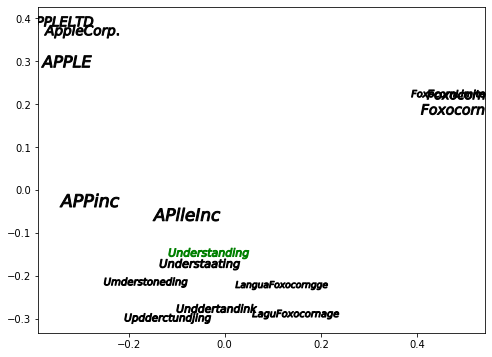

In [51]:
import sklearn.decomposition
import matplotlib.pyplot as plt


words = ['APlle Inc', 'Foxocorn Limited Corp', 'Understanding',
         'Apple Corp.', 'Foxocorn inc', 'Updderctundjing',
         'APPLE', 'Foxocorn', 'Understaating',
         'APP inc', 'LaguFoxocornage', 'Unddertandink',
         'APPLE LTD', 'LanguaFoxocorngge', 'Umderstoneding']

# Create word embeddings
word_embeddings = simcse_model.encode(words)

# Project embeddings on plane using the PCA
projection_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(word_embeddings)

# Draw words on plane
f = plt.figure(figsize=(8, 6))

for j in range(len(projection_2d)):
    plt.scatter(projection_2d[j, 0], projection_2d[j, 1],
                marker=('$' + words[j] + '$'),
                s=500 * len(words[j]), label=j,
                facecolors='green' if words[j]
                            in ['Natural', 'Language', 'Understanding'] else 'black')

plt.show()

# How sup-word tokenizer works 

In [54]:
%%time
from random import randint

i = randint(0, len(a))

sent1 = a.iloc[i]['name']
sent2 = b.iloc[i]['name']

simcse_model.tokenizer.tokenize(sent1),\
simcse_model.tokenizer.tokenize(sent2),\
sent1,\
sent2,\
simcse_model.tokenizer.batch_encode_plus([sent1,sent2])

CPU times: user 2.4 ms, sys: 673 µs, total: 3.08 ms
Wall time: 1.95 ms


(['mc', 'sr', '##l'],
 ['mc', 's', '.', 'r', '.', 'l', '.'],
 'MC SRL',
 'MC S.r.l.',
 {'input_ids': [[101, 11338, 5034, 2140, 102], [101, 11338, 1055, 1012, 1054, 1012, 1048, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]})

In [55]:
encoded = simcse_model.encode(a.norm_ws.tolist(), 
                batch_size=64,
                max_length= 20)

100%|██████████| 371/371 [00:02<00:00, 135.88it/s]


In [56]:
encoded_b = simcse_model.encode(b.norm_ws.tolist(), 
                batch_size=64,
                max_length= 20)

100%|██████████| 371/371 [00:02<00:00, 139.04it/s]


In [57]:
import torch
from torchmetrics.functional import pairwise_cosine_similarity

In [58]:
# C = torch.einsum('id,jd->ij', torch.tensor(word_embeddings_a),torch.tensor(word_embeddings_b)).numpy()
simcse_emb_sim = pairwise_cosine_similarity(torch.tensor(encoded),torch.tensor(encoded_b)).numpy()

/tmp/ipykernel_840/1793419373.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  simcse_emb_sim = pairwise_cosine_similarity(torch.tensor(encoded),torch.tensor(encoded_b)).numpy()


In [66]:
from tqdm import tqdm
correct = 0
mistakes= []
for i in tqdm(range(len(a))): 
    sim = simcse_emb_sim[i]
    sorted_data = np.argsort(sim,axis=0)
    top_sim = sorted_data[::-1][:15]
    if b.iloc[i]['name'] in b.iloc[top_sim].name.tolist():
        correct +=1
    else:
        mistakes.append({'a_name': a.iloc[i]['name'], 'b_name': b.iloc[i]['name'], 'sim': b.iloc[top_sim].name.tolist(),'scores':sim[top_sim]})

100%|██████████| 23685/23685 [00:45<00:00, 519.93it/s]


In [62]:
correct/len(a), correct

(0.9986067131095631, 23652)

In [65]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_colwidth',None)

pd.DataFrame(mistakes)

,a_name,b_name,sim,scores
0,ARB Bhd,ARB Berhad,"[ARYZTA AG, Argonne National Laboratory, Arlo Technologies, Inc., ArQule, Inc., ARRIS Technology, Inc., Arff Ltd, Arvind Limited, Rohde & Schwarz GmbH & Co. KG, Wonhe High-Tech International, Inc., Argan, Inc.]","[0.8552982, 0.8548779, 0.84439576, 0.8436462, 0.83937037, 0.8362359, 0.83240414, 0.8271892, 0.8130536, 0.8130367]"
1,ASEC SA,Asec Spolka Akcyjna,"[Asuragen, Inc., ASDERA LLC, ASE Korea, Inc., ASGN Incorporated, Asembia, Astika Holdings, Inc., Asesoramiento Bruch S.L., AST International, Aseptico, Inc., Asterias Biotherapeutics, Inc.]","[0.8922901, 0.8920481, 0.8852093, 0.87481755, 0.87131864, 0.86509407, 0.8623942, 0.861648, 0.8612921, 0.8580705]"
2,Altruis Group LLC,"Altrius Group, LLC","[Altria Group, Inc., eMedia Group Inc., EMC Insurance Group Inc., Altisource S.À R.L., REAC Group, Inc., Sumitomo Mitsui Financial Group, Inc., Sumitomo Mitsui Financial Group, Inc., Altec Industries, Inc., REV Group, Inc., Oben Holding Group S.A.C.]","[0.92264295, 0.85787165, 0.854352, 0.8518733, 0.8493804, 0.8461913, 0.8461913, 0.8450208, 0.84239376, 0.8403715]"
3,Apollo Acquisition Corp,Apolo Acquisition Corp.,"[ApolloBio Corp., Apollo Solar Energy, Inc., Apollovej Aps, Apollo Medical Holdings, Inc., Apollo Global Securities, LLC, Apollo Holdings Limited, Apollo Commercial Real Estate Finance, Inc., Apollo Residential Mortgage, Inc., Apollo Education Group, Inc., Apollo Electronics Sp Z O O]","[0.9487492, 0.8857626, 0.8758639, 0.87388766, 0.86533517, 0.8622784, 0.86111605, 0.85732204, 0.8544752, 0.8463139]"
4,CAPP,CAPP/USA,"[CapLine, CAP ApS, Capsugel US, LLC, Capsa S.R.L., Capri Holdings Limited, Capsugel, Capgemini SE, CAP IM Supply, Inc., Cap'ter Methanisation, Capstone Therapeutics Corp.]","[0.87612504, 0.871716, 0.8716587, 0.86650026, 0.8588246, 0.85234326, 0.8390504, 0.83229005, 0.8305428, 0.8245619]"
5,CARGO,CAR'GO,"[FreightCar America, Inc., Transportation Security Agency, The Transportation Security Administration, FLEETCOR Technologies, Inc., Fleet Management Solutions, Inc., FleetNet America, Inc., Transportation and Logistics Systems, Inc., Freightliner Australia Pty Ltd., FreightCar Rail Services, LLC, Fleet Laboratories Ltd.]","[0.8176307, 0.80577165, 0.78611517, 0.7847837, 0.7729336, 0.7728646, 0.7706685, 0.76939726, 0.7683836, 0.7659666]"
6,CG Consulting LLC,CG3 Consulting LLC,"[CGC Inc., BGC LLC, Challenge Mfg. Company, LLC, CGR63, LLC, CGG, ABG-Camuto, LLC, Cgt Company Limited, RGC Resources, Inc., CG Visions Inc., CCBCC Operations, LLC]","[0.9602274, 0.88710696, 0.8623779, 0.85275215, 0.85227203, 0.8453989, 0.8444853, 0.8442348, 0.84265685, 0.83740836]"
7,Cohen and Co Inc,"Cohn & Company, Inc.","[Best Buy Co., Inc., Conopco, Inc., Alco Inc., NMC, Inc., Eni US Operating Co., Inc., Revett Mining Company, Inc., Daniels Corporate Advisory Company, Inc., The Bank of New York Company, Inc., Connexity, Inc., Southern Nuclear Operating Company, Inc.]","[0.8268777, 0.80815864, 0.79910934, 0.7914149, 0.7904204, 0.78747845, 0.7873854, 0.7860084, 0.78377795, 0.7830011]"
8,Cure Pharmaceuticals Corp,CURE Pharmaceutical Corporation,"[Remedy Pharmaceuticals, Inc., Care Pharmaceuticals Pty Limited, Conatus Pharmaceuticals Inc., Belcher Pharmaceuticals, LLC, Medexus Pharmaceuticals Inc., Checkmate Pharmaceuticals, Inc., Reata Pharmaceuticals, Inc., Biotest Pharmaceuticals Corporation, Boehringer Ingelheim Biopharmaceuticals (China) Co., Ltd., Medison Pharma Limited]","[0.92161274, 0.9182515, 0.9036981, 0.8993929, 0.89658976, 0.8960027, 0.89562, 0.89362234, 0.89178824, 0.89056516]"
9,Customer Financial Services,Custer Financial Services,"[Community Financial Services, Inc., Provident Financial Services, Inc., Wahlstedt Sageryd Financial Services Ab, Ameriprise Financial Services, LLC, National Financial Services LLC, Customers Ltd., Customer Systems PLC, Discover Financial Services, AmTrust Financial Services, Inc., Citizens Financial Services, Inc.]","[0.90742433, 0.9064558, 0.88704

In [29]:

i = 0
sim = s[i]
sorted_data = np.argsort(sim,axis=0)
top_sim = sorted_data[::-1][1:30]

In [25]:
correct

1476

In [135]:
!pip install faiss-gpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 22.4 MB/s eta 0:00:0000:0100:01


In [136]:
simcse_model.build_index(a.name.tolist())

12/10/2022 21:38:12 - INFO - faiss.loader -   Loading faiss with AVX2 support.
12/10/2022 21:38:12 - INFO - faiss.loader -   Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
12/10/2022 21:38:12 - INFO - faiss.loader -   Loading faiss.
12/10/2022 21:38:12 - INFO - faiss.loader -   Successfully loaded faiss.
12/10/2022 21:38:12 - INFO - simcse.core -   Encoding embeddings for sentences...
100%|██████████| 371/371 [00:09<00:00, 37.58it/s]
12/10/2022 21:38:22 - INFO - simcse.core -   Building index...
12/10/2022 21:38:22 - INFO - simcse.core -   Use GPU-version faiss


RuntimeError: Error in virtual void faiss::gpu::StandardGpuResourcesImpl::initializeForDevice(int) at /project/faiss/faiss/gpu/StandardGpuResources.cpp:283: Error: 'err == cudaSuccess' failed: failed to cudaHostAlloc 268435456 bytes for CPU <-> GPU async copy buffer (error 2 out of memory)

In [ ]:
from random import randint

i = randint(0, len(a))
b.iloc[i]['name'], a.iloc[i]['name']

In [ ]:
results = simcse_model.search(queries=list(b.name))

In [ ]:
len(results)

In [131]:
results[0]

NameError: name 'results' is not defined